# CE-40719: Deep Learning
## HW5 - VAE (100 points)

#### Name: AmirHossein Mohammadi
#### Student No.: 99201081

In [27]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [28]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 100
x_dim  = 784
hidden_dim = 400
latent_dim = 200
lr = 1e-3
epochs = 30

In [29]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

train_dataset = MNIST("./mnist/", transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST("./mnist/", transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

In [30]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        h_= self.LeakyReLU(self.FC_input(x))
        h_= self.LeakyReLU(self.FC_input2(h_))
        mean= self.FC_mean(h_)
        log_var= self.FC_var(h_)              
        return mean, log_var

In [31]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h= self.LeakyReLU(self.FC_hidden(x))
        h= self.LeakyReLU(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [32]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)              
        z = mean + var*epsilon                          
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat= self.Decoder(z)
        return x_hat, mean, log_var

In [33]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [34]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [35]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  173.58387000795597
	Epoch 2 complete! 	Average Loss:  129.73038415262417
	Epoch 3 complete! 	Average Loss:  117.06932353075439
	Epoch 4 complete! 	Average Loss:  112.60420694647328
	Epoch 5 complete! 	Average Loss:  109.86951964211185
	Epoch 6 complete! 	Average Loss:  108.24756757682074
	Epoch 7 complete! 	Average Loss:  107.0578507310361
	Epoch 8 complete! 	Average Loss:  106.23814205316152
	Epoch 9 complete! 	Average Loss:  105.48352767307492
	Epoch 10 complete! 	Average Loss:  104.7335143207429
	Epoch 11 complete! 	Average Loss:  104.23175160097558
	Epoch 12 complete! 	Average Loss:  103.77003325855593
	Epoch 13 complete! 	Average Loss:  103.38808464954612
	Epoch 14 complete! 	Average Loss:  103.05486362361749
	Epoch 15 complete! 	Average Loss:  102.73624928265859
	Epoch 16 complete! 	Average Loss:  102.52804177209411
	Epoch 17 complete! 	Average Loss:  102.27409076977254
	Epoch 18 complete! 	Average Loss:  102.02664414649416

In [17]:
import matplotlib.pyplot as plt

In [18]:


def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())



In [19]:


with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)



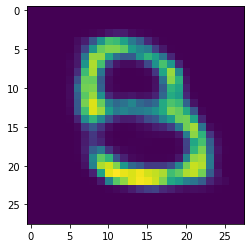

In [21]:


show_image(generated_images, idx=12)



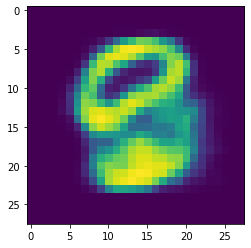

In [24]:
show_image(generated_images, idx=7)

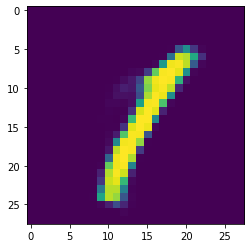

In [25]:
show_image(generated_images, idx=4)

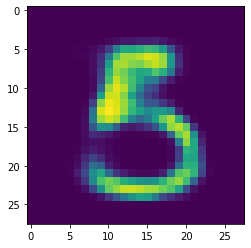

In [26]:
show_image(generated_images, idx=2)